## multi-to-multi step forecast

In [1]:
import os
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

filename = 'dataset/shampoo-three-year.csv'

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


#### preprocessing for time-step forecasting

In [2]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용

참고:

original data
diff data
-->

266 145 183 119 ... 224
       -120  37  -63 ...   -7
       
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, split_index=12):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = split_index
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series,
                                                                                               x_steps=4, y_steps=3, split_index=17)
# transform original value to diff value
diff_interval = 1
diff_series = difference(origin_series, diff_interval)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, 
                                                                   x_steps=4, y_steps=3, split_index=17)

In [3]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (17, 4)
training Y data shape: (17, 3)
test X data shape: (13, 4)
test Y data shape: (13, 3)


In [4]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (17, 4)
training Y data shape: (17, 3)
test X data shape: (12, 4)
test Y data shape: (12, 3)


In [5]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [6]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 3)
test X data shape: (12, 4)
test Y data shape: (12, 3)


#### change shape for (LSTM or RNN)

In [7]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [8]:
num_epochs = 3000
batch_size=4
forecast_step = 3

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(forecast_step)) # output = forecast_step
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
16/16 [==============================] - 0s 24ms/step - loss: 0.1694
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1625
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 475us/step - loss: 0.1557
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 486us/step - loss: 0.1489
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 827us/step - loss: 0.1422
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1355
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 640us/step - loss: 0.1289
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 625us/step - loss: 0.1225
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 672us/step - loss: 0.1162
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 624us/step - loss: 0.1101
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 664us/step - loss: 0.1042
epo

16/16 [==============================] - 0s 937us/step - loss: 0.0358
epochs : 90
Epoch 1/1
16/16 [==============================] - 0s 630us/step - loss: 0.0358
epochs : 91
Epoch 1/1
16/16 [==============================] - 0s 645us/step - loss: 0.0358
epochs : 92
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0358
epochs : 93
Epoch 1/1
16/16 [==============================] - 0s 669us/step - loss: 0.0357
epochs : 94
Epoch 1/1
16/16 [==============================] - 0s 618us/step - loss: 0.0357
epochs : 95
Epoch 1/1
16/16 [==============================] - 0s 642us/step - loss: 0.0357
epochs : 96
Epoch 1/1
16/16 [==============================] - 0s 679us/step - loss: 0.0356
epochs : 97
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0356
epochs : 98
Epoch 1/1
16/16 [==============================] - 0s 567us/step - loss: 0.0356
epochs : 99
Epoch 1/1
16/16 [==============================] - 0s 711us/step - loss: 0.0356
epochs : 100
E

16/16 [==============================] - 0s 652us/step - loss: 0.0340
epochs : 178
Epoch 1/1
16/16 [==============================] - 0s 521us/step - loss: 0.0340
epochs : 179
Epoch 1/1
16/16 [==============================] - 0s 696us/step - loss: 0.0340
epochs : 180
Epoch 1/1
16/16 [==============================] - 0s 458us/step - loss: 0.0340
epochs : 181
Epoch 1/1
16/16 [==============================] - 0s 519us/step - loss: 0.0339
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 550us/step - loss: 0.0339
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 835us/step - loss: 0.0339
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 738us/step - loss: 0.0339
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 648us/step - loss: 0.0339
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 676us/step - loss: 0.0339
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 753us/step - loss: 0.0339


16/16 [==============================] - 0s 684us/step - loss: 0.0329
epochs : 266
Epoch 1/1
16/16 [==============================] - 0s 643us/step - loss: 0.0329
epochs : 267
Epoch 1/1
16/16 [==============================] - 0s 551us/step - loss: 0.0329
epochs : 268
Epoch 1/1
16/16 [==============================] - 0s 485us/step - loss: 0.0329
epochs : 269
Epoch 1/1
16/16 [==============================] - 0s 454us/step - loss: 0.0329
epochs : 270
Epoch 1/1
16/16 [==============================] - 0s 583us/step - loss: 0.0329
epochs : 271
Epoch 1/1
16/16 [==============================] - 0s 561us/step - loss: 0.0328
epochs : 272
Epoch 1/1
16/16 [==============================] - 0s 624us/step - loss: 0.0328
epochs : 273
Epoch 1/1
16/16 [==============================] - 0s 623us/step - loss: 0.0328
epochs : 274
Epoch 1/1
16/16 [==============================] - 0s 569us/step - loss: 0.0328
epochs : 275
Epoch 1/1
16/16 [==============================] - 0s 694us/step - loss: 0.0328


16/16 [==============================] - 0s 643us/step - loss: 0.0321
epochs : 354
Epoch 1/1
16/16 [==============================] - 0s 463us/step - loss: 0.0321
epochs : 355
Epoch 1/1
16/16 [==============================] - 0s 404us/step - loss: 0.0321
epochs : 356
Epoch 1/1
16/16 [==============================] - 0s 618us/step - loss: 0.0321
epochs : 357
Epoch 1/1
16/16 [==============================] - 0s 719us/step - loss: 0.0320
epochs : 358
Epoch 1/1
16/16 [==============================] - 0s 704us/step - loss: 0.0320
epochs : 359
Epoch 1/1
16/16 [==============================] - 0s 608us/step - loss: 0.0320
epochs : 360
Epoch 1/1
16/16 [==============================] - 0s 511us/step - loss: 0.0320
epochs : 361
Epoch 1/1
16/16 [==============================] - 0s 684us/step - loss: 0.0320
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 677us/step - loss: 0.0320
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 925us/step - loss: 0.0320


16/16 [==============================] - 0s 575us/step - loss: 0.0314
epochs : 442
Epoch 1/1
16/16 [==============================] - 0s 584us/step - loss: 0.0314
epochs : 443
Epoch 1/1
16/16 [==============================] - 0s 785us/step - loss: 0.0314
epochs : 444
Epoch 1/1
16/16 [==============================] - 0s 474us/step - loss: 0.0314
epochs : 445
Epoch 1/1
16/16 [==============================] - 0s 465us/step - loss: 0.0314
epochs : 446
Epoch 1/1
16/16 [==============================] - 0s 554us/step - loss: 0.0313
epochs : 447
Epoch 1/1
16/16 [==============================] - 0s 625us/step - loss: 0.0313
epochs : 448
Epoch 1/1
16/16 [==============================] - 0s 732us/step - loss: 0.0313
epochs : 449
Epoch 1/1
16/16 [==============================] - 0s 554us/step - loss: 0.0313
epochs : 450
Epoch 1/1
16/16 [==============================] - 0s 591us/step - loss: 0.0313
epochs : 451
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0313
ep

16/16 [==============================] - 0s 643us/step - loss: 0.0308
epochs : 530
Epoch 1/1
16/16 [==============================] - 0s 503us/step - loss: 0.0308
epochs : 531
Epoch 1/1
16/16 [==============================] - 0s 733us/step - loss: 0.0308
epochs : 532
Epoch 1/1
16/16 [==============================] - 0s 662us/step - loss: 0.0308
epochs : 533
Epoch 1/1
16/16 [==============================] - 0s 941us/step - loss: 0.0308
epochs : 534
Epoch 1/1
16/16 [==============================] - 0s 533us/step - loss: 0.0308
epochs : 535
Epoch 1/1
16/16 [==============================] - 0s 663us/step - loss: 0.0308
epochs : 536
Epoch 1/1
16/16 [==============================] - 0s 916us/step - loss: 0.0307
epochs : 537
Epoch 1/1
16/16 [==============================] - 0s 500us/step - loss: 0.0307
epochs : 538
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0307
epochs : 539
Epoch 1/1
16/16 [==============================] - 0s 614us/step - loss: 0.0307
ep

16/16 [==============================] - 0s 702us/step - loss: 0.0303
epochs : 618
Epoch 1/1
16/16 [==============================] - 0s 575us/step - loss: 0.0303
epochs : 619
Epoch 1/1
16/16 [==============================] - 0s 453us/step - loss: 0.0303
epochs : 620
Epoch 1/1
16/16 [==============================] - 0s 477us/step - loss: 0.0303
epochs : 621
Epoch 1/1
16/16 [==============================] - 0s 535us/step - loss: 0.0303
epochs : 622
Epoch 1/1
16/16 [==============================] - 0s 614us/step - loss: 0.0303
epochs : 623
Epoch 1/1
16/16 [==============================] - 0s 466us/step - loss: 0.0303
epochs : 624
Epoch 1/1
16/16 [==============================] - 0s 564us/step - loss: 0.0303
epochs : 625
Epoch 1/1
16/16 [==============================] - 0s 558us/step - loss: 0.0302
epochs : 626
Epoch 1/1
16/16 [==============================] - 0s 555us/step - loss: 0.0302
epochs : 627
Epoch 1/1
16/16 [==============================] - 0s 587us/step - loss: 0.0302


16/16 [==============================] - 0s 545us/step - loss: 0.0299
epochs : 706
Epoch 1/1
16/16 [==============================] - 0s 441us/step - loss: 0.0299
epochs : 707
Epoch 1/1
16/16 [==============================] - 0s 473us/step - loss: 0.0299
epochs : 708
Epoch 1/1
16/16 [==============================] - 0s 528us/step - loss: 0.0299
epochs : 709
Epoch 1/1
16/16 [==============================] - 0s 726us/step - loss: 0.0299
epochs : 710
Epoch 1/1
16/16 [==============================] - 0s 976us/step - loss: 0.0299
epochs : 711
Epoch 1/1
16/16 [==============================] - 0s 534us/step - loss: 0.0298
epochs : 712
Epoch 1/1
16/16 [==============================] - 0s 949us/step - loss: 0.0298
epochs : 713
Epoch 1/1
16/16 [==============================] - 0s 640us/step - loss: 0.0298
epochs : 714
Epoch 1/1
16/16 [==============================] - 0s 575us/step - loss: 0.0298
epochs : 715
Epoch 1/1
16/16 [==============================] - 0s 702us/step - loss: 0.0298


16/16 [==============================] - 0s 694us/step - loss: 0.0295
epochs : 794
Epoch 1/1
16/16 [==============================] - 0s 528us/step - loss: 0.0295
epochs : 795
Epoch 1/1
16/16 [==============================] - 0s 537us/step - loss: 0.0295
epochs : 796
Epoch 1/1
16/16 [==============================] - 0s 726us/step - loss: 0.0295
epochs : 797
Epoch 1/1
16/16 [==============================] - 0s 678us/step - loss: 0.0295
epochs : 798
Epoch 1/1
16/16 [==============================] - 0s 602us/step - loss: 0.0295
epochs : 799
Epoch 1/1
16/16 [==============================] - 0s 564us/step - loss: 0.0295
epochs : 800
Epoch 1/1
16/16 [==============================] - 0s 680us/step - loss: 0.0295
epochs : 801
Epoch 1/1
16/16 [==============================] - 0s 618us/step - loss: 0.0295
epochs : 802
Epoch 1/1
16/16 [==============================] - 0s 543us/step - loss: 0.0295
epochs : 803
Epoch 1/1
16/16 [==============================] - 0s 605us/step - loss: 0.0295


16/16 [==============================] - 0s 466us/step - loss: 0.0292
epochs : 882
Epoch 1/1
16/16 [==============================] - 0s 477us/step - loss: 0.0292
epochs : 883
Epoch 1/1
16/16 [==============================] - 0s 680us/step - loss: 0.0292
epochs : 884
Epoch 1/1
16/16 [==============================] - 0s 494us/step - loss: 0.0292
epochs : 885
Epoch 1/1
16/16 [==============================] - 0s 572us/step - loss: 0.0292
epochs : 886
Epoch 1/1
16/16 [==============================] - 0s 519us/step - loss: 0.0292
epochs : 887
Epoch 1/1
16/16 [==============================] - 0s 564us/step - loss: 0.0292
epochs : 888
Epoch 1/1
16/16 [==============================] - 0s 580us/step - loss: 0.0292
epochs : 889
Epoch 1/1
16/16 [==============================] - 0s 565us/step - loss: 0.0292
epochs : 890
Epoch 1/1
16/16 [==============================] - 0s 563us/step - loss: 0.0292
epochs : 891
Epoch 1/1
16/16 [==============================] - 0s 546us/step - loss: 0.0292


16/16 [==============================] - 0s 495us/step - loss: 0.0290
epochs : 970
Epoch 1/1
16/16 [==============================] - 0s 467us/step - loss: 0.0290
epochs : 971
Epoch 1/1
16/16 [==============================] - 0s 470us/step - loss: 0.0290
epochs : 972
Epoch 1/1
16/16 [==============================] - 0s 601us/step - loss: 0.0290
epochs : 973
Epoch 1/1
16/16 [==============================] - 0s 610us/step - loss: 0.0290
epochs : 974
Epoch 1/1
16/16 [==============================] - 0s 566us/step - loss: 0.0290
epochs : 975
Epoch 1/1
16/16 [==============================] - 0s 625us/step - loss: 0.0290
epochs : 976
Epoch 1/1
16/16 [==============================] - 0s 541us/step - loss: 0.0290
epochs : 977
Epoch 1/1
16/16 [==============================] - 0s 533us/step - loss: 0.0290
epochs : 978
Epoch 1/1
16/16 [==============================] - 0s 530us/step - loss: 0.0290
epochs : 979
Epoch 1/1
16/16 [==============================] - 0s 879us/step - loss: 0.0290


16/16 [==============================] - 0s 577us/step - loss: 0.0288
epochs : 1057
Epoch 1/1
16/16 [==============================] - 0s 516us/step - loss: 0.0288
epochs : 1058
Epoch 1/1
16/16 [==============================] - 0s 661us/step - loss: 0.0288
epochs : 1059
Epoch 1/1
16/16 [==============================] - 0s 632us/step - loss: 0.0288
epochs : 1060
Epoch 1/1
16/16 [==============================] - 0s 521us/step - loss: 0.0288
epochs : 1061
Epoch 1/1
16/16 [==============================] - 0s 708us/step - loss: 0.0288
epochs : 1062
Epoch 1/1
16/16 [==============================] - 0s 604us/step - loss: 0.0288
epochs : 1063
Epoch 1/1
16/16 [==============================] - 0s 492us/step - loss: 0.0288
epochs : 1064
Epoch 1/1
16/16 [==============================] - 0s 694us/step - loss: 0.0288
epochs : 1065
Epoch 1/1
16/16 [==============================] - 0s 622us/step - loss: 0.0288
epochs : 1066
Epoch 1/1
16/16 [==============================] - 0s 582us/step - los

16/16 [==============================] - 0s 511us/step - loss: 0.0287
epochs : 1144
Epoch 1/1
16/16 [==============================] - 0s 504us/step - loss: 0.0287
epochs : 1145
Epoch 1/1
16/16 [==============================] - 0s 897us/step - loss: 0.0287
epochs : 1146
Epoch 1/1
16/16 [==============================] - 0s 679us/step - loss: 0.0287
epochs : 1147
Epoch 1/1
16/16 [==============================] - 0s 906us/step - loss: 0.0287
epochs : 1148
Epoch 1/1
16/16 [==============================] - 0s 656us/step - loss: 0.0287
epochs : 1149
Epoch 1/1
16/16 [==============================] - 0s 536us/step - loss: 0.0287
epochs : 1150
Epoch 1/1
16/16 [==============================] - 0s 617us/step - loss: 0.0287
epochs : 1151
Epoch 1/1
16/16 [==============================] - 0s 559us/step - loss: 0.0286
epochs : 1152
Epoch 1/1
16/16 [==============================] - 0s 521us/step - loss: 0.0286
epochs : 1153
Epoch 1/1
16/16 [==============================] - 0s 603us/step - los

16/16 [==============================] - 0s 537us/step - loss: 0.0285
epochs : 1231
Epoch 1/1
16/16 [==============================] - 0s 462us/step - loss: 0.0285
epochs : 1232
Epoch 1/1
16/16 [==============================] - 0s 500us/step - loss: 0.0285
epochs : 1233
Epoch 1/1
16/16 [==============================] - 0s 534us/step - loss: 0.0285
epochs : 1234
Epoch 1/1
16/16 [==============================] - 0s 541us/step - loss: 0.0285
epochs : 1235
Epoch 1/1
16/16 [==============================] - 0s 370us/step - loss: 0.0285
epochs : 1236
Epoch 1/1
16/16 [==============================] - 0s 524us/step - loss: 0.0285
epochs : 1237
Epoch 1/1
16/16 [==============================] - 0s 487us/step - loss: 0.0285
epochs : 1238
Epoch 1/1
16/16 [==============================] - 0s 444us/step - loss: 0.0285
epochs : 1239
Epoch 1/1
16/16 [==============================] - 0s 405us/step - loss: 0.0285
epochs : 1240
Epoch 1/1
16/16 [==============================] - 0s 531us/step - los

16/16 [==============================] - 0s 458us/step - loss: 0.0284
epochs : 1318
Epoch 1/1
16/16 [==============================] - 0s 491us/step - loss: 0.0284
epochs : 1319
Epoch 1/1
16/16 [==============================] - 0s 656us/step - loss: 0.0284
epochs : 1320
Epoch 1/1
16/16 [==============================] - 0s 518us/step - loss: 0.0284
epochs : 1321
Epoch 1/1
16/16 [==============================] - 0s 990us/step - loss: 0.0284
epochs : 1322
Epoch 1/1
16/16 [==============================] - 0s 828us/step - loss: 0.0284
epochs : 1323
Epoch 1/1
16/16 [==============================] - 0s 577us/step - loss: 0.0284
epochs : 1324
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0284
epochs : 1325
Epoch 1/1
16/16 [==============================] - 0s 529us/step - loss: 0.0284
epochs : 1326
Epoch 1/1
16/16 [==============================] - 0s 525us/step - loss: 0.0284
epochs : 1327
Epoch 1/1
16/16 [==============================] - 0s 801us/step - loss:

16/16 [==============================] - 0s 576us/step - loss: 0.0283
epochs : 1405
Epoch 1/1
16/16 [==============================] - 0s 594us/step - loss: 0.0283
epochs : 1406
Epoch 1/1
16/16 [==============================] - 0s 592us/step - loss: 0.0283
epochs : 1407
Epoch 1/1
16/16 [==============================] - 0s 549us/step - loss: 0.0283
epochs : 1408
Epoch 1/1
16/16 [==============================] - 0s 746us/step - loss: 0.0283
epochs : 1409
Epoch 1/1
16/16 [==============================] - 0s 693us/step - loss: 0.0283
epochs : 1410
Epoch 1/1
16/16 [==============================] - 0s 559us/step - loss: 0.0283
epochs : 1411
Epoch 1/1
16/16 [==============================] - 0s 510us/step - loss: 0.0283
epochs : 1412
Epoch 1/1
16/16 [==============================] - 0s 649us/step - loss: 0.0283
epochs : 1413
Epoch 1/1
16/16 [==============================] - 0s 637us/step - loss: 0.0283
epochs : 1414
Epoch 1/1
16/16 [==============================] - 0s 684us/step - los

16/16 [==============================] - 0s 595us/step - loss: 0.0283
epochs : 1492
Epoch 1/1
16/16 [==============================] - 0s 502us/step - loss: 0.0283
epochs : 1493
Epoch 1/1
16/16 [==============================] - 0s 691us/step - loss: 0.0283
epochs : 1494
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0283
epochs : 1495
Epoch 1/1
16/16 [==============================] - 0s 952us/step - loss: 0.0283
epochs : 1496
Epoch 1/1
16/16 [==============================] - 0s 471us/step - loss: 0.0283
epochs : 1497
Epoch 1/1
16/16 [==============================] - 0s 515us/step - loss: 0.0283
epochs : 1498
Epoch 1/1
16/16 [==============================] - 0s 946us/step - loss: 0.0283
epochs : 1499
Epoch 1/1
16/16 [==============================] - 0s 653us/step - loss: 0.0283
epochs : 1500
Epoch 1/1
16/16 [==============================] - 0s 538us/step - loss: 0.0283
epochs : 1501
Epoch 1/1
16/16 [==============================] - 0s 601us/step - los

16/16 [==============================] - 0s 477us/step - loss: 0.0282
epochs : 1579
Epoch 1/1
16/16 [==============================] - 0s 483us/step - loss: 0.0282
epochs : 1580
Epoch 1/1
16/16 [==============================] - 0s 640us/step - loss: 0.0282
epochs : 1581
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0282
epochs : 1582
Epoch 1/1
16/16 [==============================] - 0s 709us/step - loss: 0.0282
epochs : 1583
Epoch 1/1
16/16 [==============================] - 0s 703us/step - loss: 0.0282
epochs : 1584
Epoch 1/1
16/16 [==============================] - 0s 744us/step - loss: 0.0282
epochs : 1585
Epoch 1/1
16/16 [==============================] - 0s 528us/step - loss: 0.0282
epochs : 1586
Epoch 1/1
16/16 [==============================] - 0s 570us/step - loss: 0.0282
epochs : 1587
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0282
epochs : 1588
Epoch 1/1
16/16 [==============================] - 0s 731us/step - loss: 0

16/16 [==============================] - 0s 497us/step - loss: 0.0282
epochs : 1666
Epoch 1/1
16/16 [==============================] - 0s 585us/step - loss: 0.0282
epochs : 1667
Epoch 1/1
16/16 [==============================] - 0s 539us/step - loss: 0.0282
epochs : 1668
Epoch 1/1
16/16 [==============================] - 0s 762us/step - loss: 0.0282
epochs : 1669
Epoch 1/1
16/16 [==============================] - 0s 664us/step - loss: 0.0282
epochs : 1670
Epoch 1/1
16/16 [==============================] - 0s 532us/step - loss: 0.0282
epochs : 1671
Epoch 1/1
16/16 [==============================] - 0s 517us/step - loss: 0.0282
epochs : 1672
Epoch 1/1
16/16 [==============================] - 0s 626us/step - loss: 0.0282
epochs : 1673
Epoch 1/1
16/16 [==============================] - 0s 535us/step - loss: 0.0282
epochs : 1674
Epoch 1/1
16/16 [==============================] - 0s 462us/step - loss: 0.0282
epochs : 1675
Epoch 1/1
16/16 [==============================] - 0s 362us/step - los

16/16 [==============================] - 0s 690us/step - loss: 0.0281
epochs : 1753
Epoch 1/1
16/16 [==============================] - 0s 698us/step - loss: 0.0281
epochs : 1754
Epoch 1/1
16/16 [==============================] - 0s 567us/step - loss: 0.0281
epochs : 1755
Epoch 1/1
16/16 [==============================] - 0s 921us/step - loss: 0.0281
epochs : 1756
Epoch 1/1
16/16 [==============================] - 0s 622us/step - loss: 0.0281
epochs : 1757
Epoch 1/1
16/16 [==============================] - 0s 588us/step - loss: 0.0281
epochs : 1758
Epoch 1/1
16/16 [==============================] - 0s 588us/step - loss: 0.0281
epochs : 1759
Epoch 1/1
16/16 [==============================] - 0s 649us/step - loss: 0.0281
epochs : 1760
Epoch 1/1
16/16 [==============================] - 0s 726us/step - loss: 0.0281
epochs : 1761
Epoch 1/1
16/16 [==============================] - 0s 693us/step - loss: 0.0281
epochs : 1762
Epoch 1/1
16/16 [==============================] - 0s 622us/step - los

16/16 [==============================] - 0s 639us/step - loss: 0.0281
epochs : 1840
Epoch 1/1
16/16 [==============================] - 0s 627us/step - loss: 0.0281
epochs : 1841
Epoch 1/1
16/16 [==============================] - 0s 492us/step - loss: 0.0281
epochs : 1842
Epoch 1/1
16/16 [==============================] - 0s 521us/step - loss: 0.0281
epochs : 1843
Epoch 1/1
16/16 [==============================] - 0s 674us/step - loss: 0.0281
epochs : 1844
Epoch 1/1
16/16 [==============================] - 0s 536us/step - loss: 0.0281
epochs : 1845
Epoch 1/1
16/16 [==============================] - 0s 735us/step - loss: 0.0281
epochs : 1846
Epoch 1/1
16/16 [==============================] - 0s 591us/step - loss: 0.0281
epochs : 1847
Epoch 1/1
16/16 [==============================] - 0s 595us/step - loss: 0.0281
epochs : 1848
Epoch 1/1
16/16 [==============================] - 0s 625us/step - loss: 0.0281
epochs : 1849
Epoch 1/1
16/16 [==============================] - 0s 555us/step - los

16/16 [==============================] - 0s 480us/step - loss: 0.0281
epochs : 1927
Epoch 1/1
16/16 [==============================] - 0s 501us/step - loss: 0.0281
epochs : 1928
Epoch 1/1
16/16 [==============================] - 0s 657us/step - loss: 0.0281
epochs : 1929
Epoch 1/1
16/16 [==============================] - 0s 611us/step - loss: 0.0281
epochs : 1930
Epoch 1/1
16/16 [==============================] - 0s 469us/step - loss: 0.0281
epochs : 1931
Epoch 1/1
16/16 [==============================] - 0s 621us/step - loss: 0.0281
epochs : 1932
Epoch 1/1
16/16 [==============================] - 0s 600us/step - loss: 0.0281
epochs : 1933
Epoch 1/1
16/16 [==============================] - 0s 974us/step - loss: 0.0280
epochs : 1934
Epoch 1/1
16/16 [==============================] - 0s 554us/step - loss: 0.0280
epochs : 1935
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0280
epochs : 1936
Epoch 1/1
16/16 [==============================] - 0s 595us/step - loss:

16/16 [==============================] - 0s 560us/step - loss: 0.0280
epochs : 2014
Epoch 1/1
16/16 [==============================] - 0s 569us/step - loss: 0.0280
epochs : 2015
Epoch 1/1
16/16 [==============================] - 0s 503us/step - loss: 0.0280
epochs : 2016
Epoch 1/1
16/16 [==============================] - 0s 518us/step - loss: 0.0280
epochs : 2017
Epoch 1/1
16/16 [==============================] - 0s 477us/step - loss: 0.0280
epochs : 2018
Epoch 1/1
16/16 [==============================] - 0s 564us/step - loss: 0.0280
epochs : 2019
Epoch 1/1
16/16 [==============================] - 0s 448us/step - loss: 0.0280
epochs : 2020
Epoch 1/1
16/16 [==============================] - 0s 769us/step - loss: 0.0280
epochs : 2021
Epoch 1/1
16/16 [==============================] - 0s 666us/step - loss: 0.0280
epochs : 2022
Epoch 1/1
16/16 [==============================] - 0s 521us/step - loss: 0.0280
epochs : 2023
Epoch 1/1
16/16 [==============================] - 0s 418us/step - los

16/16 [==============================] - 0s 522us/step - loss: 0.0280
epochs : 2101
Epoch 1/1
16/16 [==============================] - 0s 681us/step - loss: 0.0280
epochs : 2102
Epoch 1/1
16/16 [==============================] - 0s 709us/step - loss: 0.0280
epochs : 2103
Epoch 1/1
16/16 [==============================] - 0s 551us/step - loss: 0.0280
epochs : 2104
Epoch 1/1
16/16 [==============================] - 0s 586us/step - loss: 0.0280
epochs : 2105
Epoch 1/1
16/16 [==============================] - 0s 922us/step - loss: 0.0280
epochs : 2106
Epoch 1/1
16/16 [==============================] - 0s 687us/step - loss: 0.0280
epochs : 2107
Epoch 1/1
16/16 [==============================] - 0s 642us/step - loss: 0.0280
epochs : 2108
Epoch 1/1
16/16 [==============================] - 0s 460us/step - loss: 0.0280
epochs : 2109
Epoch 1/1
16/16 [==============================] - 0s 609us/step - loss: 0.0280
epochs : 2110
Epoch 1/1
16/16 [==============================] - 0s 617us/step - los

16/16 [==============================] - 0s 660us/step - loss: 0.0279
epochs : 2188
Epoch 1/1
16/16 [==============================] - 0s 752us/step - loss: 0.0279
epochs : 2189
Epoch 1/1
16/16 [==============================] - 0s 682us/step - loss: 0.0279
epochs : 2190
Epoch 1/1
16/16 [==============================] - 0s 436us/step - loss: 0.0279
epochs : 2191
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0279
epochs : 2192
Epoch 1/1
16/16 [==============================] - 0s 533us/step - loss: 0.0279
epochs : 2193
Epoch 1/1
16/16 [==============================] - 0s 657us/step - loss: 0.0279
epochs : 2194
Epoch 1/1
16/16 [==============================] - 0s 611us/step - loss: 0.0279
epochs : 2195
Epoch 1/1
16/16 [==============================] - 0s 639us/step - loss: 0.0279
epochs : 2196
Epoch 1/1
16/16 [==============================] - 0s 590us/step - loss: 0.0279
epochs : 2197
Epoch 1/1
16/16 [==============================] - 0s 770us/step - los

16/16 [==============================] - 0s 574us/step - loss: 0.0278
epochs : 2275
Epoch 1/1
16/16 [==============================] - 0s 539us/step - loss: 0.0278
epochs : 2276
Epoch 1/1
16/16 [==============================] - 0s 620us/step - loss: 0.0278
epochs : 2277
Epoch 1/1
16/16 [==============================] - 0s 639us/step - loss: 0.0278
epochs : 2278
Epoch 1/1
16/16 [==============================] - 0s 822us/step - loss: 0.0278
epochs : 2279
Epoch 1/1
16/16 [==============================] - 0s 463us/step - loss: 0.0278
epochs : 2280
Epoch 1/1
16/16 [==============================] - 0s 690us/step - loss: 0.0278
epochs : 2281
Epoch 1/1
16/16 [==============================] - 0s 812us/step - loss: 0.0278
epochs : 2282
Epoch 1/1
16/16 [==============================] - 0s 778us/step - loss: 0.0278
epochs : 2283
Epoch 1/1
16/16 [==============================] - 0s 600us/step - loss: 0.0278
epochs : 2284
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss:

16/16 [==============================] - 0s 483us/step - loss: 0.0276
epochs : 2362
Epoch 1/1
16/16 [==============================] - 0s 460us/step - loss: 0.0276
epochs : 2363
Epoch 1/1
16/16 [==============================] - 0s 497us/step - loss: 0.0276
epochs : 2364
Epoch 1/1
16/16 [==============================] - 0s 568us/step - loss: 0.0276
epochs : 2365
Epoch 1/1
16/16 [==============================] - 0s 495us/step - loss: 0.0276
epochs : 2366
Epoch 1/1
16/16 [==============================] - 0s 566us/step - loss: 0.0276
epochs : 2367
Epoch 1/1
16/16 [==============================] - 0s 566us/step - loss: 0.0276
epochs : 2368
Epoch 1/1
16/16 [==============================] - 0s 531us/step - loss: 0.0276
epochs : 2369
Epoch 1/1
16/16 [==============================] - 0s 649us/step - loss: 0.0276
epochs : 2370
Epoch 1/1
16/16 [==============================] - 0s 647us/step - loss: 0.0276
epochs : 2371
Epoch 1/1
16/16 [==============================] - 0s 396us/step - los

16/16 [==============================] - 0s 906us/step - loss: 0.0271
epochs : 2449
Epoch 1/1
16/16 [==============================] - 0s 638us/step - loss: 0.0271
epochs : 2450
Epoch 1/1
16/16 [==============================] - 0s 471us/step - loss: 0.0272
epochs : 2451
Epoch 1/1
16/16 [==============================] - 0s 873us/step - loss: 0.0272
epochs : 2452
Epoch 1/1
16/16 [==============================] - 0s 716us/step - loss: 0.0272
epochs : 2453
Epoch 1/1
16/16 [==============================] - 0s 634us/step - loss: 0.0272
epochs : 2454
Epoch 1/1
16/16 [==============================] - 0s 920us/step - loss: 0.0272
epochs : 2455
Epoch 1/1
16/16 [==============================] - 0s 524us/step - loss: 0.0272
epochs : 2456
Epoch 1/1
16/16 [==============================] - 0s 624us/step - loss: 0.0272
epochs : 2457
Epoch 1/1
16/16 [==============================] - 0s 686us/step - loss: 0.0272
epochs : 2458
Epoch 1/1
16/16 [==============================] - 0s 725us/step - los

16/16 [==============================] - 0s 648us/step - loss: 0.0273
epochs : 2536
Epoch 1/1
16/16 [==============================] - 0s 503us/step - loss: 0.0273
epochs : 2537
Epoch 1/1
16/16 [==============================] - 0s 673us/step - loss: 0.0273
epochs : 2538
Epoch 1/1
16/16 [==============================] - 0s 788us/step - loss: 0.0273
epochs : 2539
Epoch 1/1
16/16 [==============================] - 0s 993us/step - loss: 0.0273
epochs : 2540
Epoch 1/1
16/16 [==============================] - 0s 565us/step - loss: 0.0273
epochs : 2541
Epoch 1/1
16/16 [==============================] - 0s 489us/step - loss: 0.0272
epochs : 2542
Epoch 1/1
16/16 [==============================] - 0s 542us/step - loss: 0.0272
epochs : 2543
Epoch 1/1
16/16 [==============================] - 0s 404us/step - loss: 0.0272
epochs : 2544
Epoch 1/1
16/16 [==============================] - 0s 978us/step - loss: 0.0272
epochs : 2545
Epoch 1/1
16/16 [==============================] - 0s 398us/step - los

16/16 [==============================] - 0s 639us/step - loss: 0.0271
epochs : 2623
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0271
epochs : 2624
Epoch 1/1
16/16 [==============================] - 0s 641us/step - loss: 0.0271
epochs : 2625
Epoch 1/1
16/16 [==============================] - 0s 568us/step - loss: 0.0271
epochs : 2626
Epoch 1/1
16/16 [==============================] - 0s 562us/step - loss: 0.0271
epochs : 2627
Epoch 1/1
16/16 [==============================] - 0s 729us/step - loss: 0.0271
epochs : 2628
Epoch 1/1
16/16 [==============================] - 0s 617us/step - loss: 0.0271
epochs : 2629
Epoch 1/1
16/16 [==============================] - 0s 479us/step - loss: 0.0271
epochs : 2630
Epoch 1/1
16/16 [==============================] - 0s 552us/step - loss: 0.0271
epochs : 2631
Epoch 1/1
16/16 [==============================] - 0s 959us/step - loss: 0.0271
epochs : 2632
Epoch 1/1
16/16 [==============================] - 0s 697us/step - loss:

16/16 [==============================] - 0s 555us/step - loss: 0.0269
epochs : 2710
Epoch 1/1
16/16 [==============================] - 0s 454us/step - loss: 0.0269
epochs : 2711
Epoch 1/1
16/16 [==============================] - 0s 434us/step - loss: 0.0269
epochs : 2712
Epoch 1/1
16/16 [==============================] - 0s 468us/step - loss: 0.0269
epochs : 2713
Epoch 1/1
16/16 [==============================] - 0s 567us/step - loss: 0.0269
epochs : 2714
Epoch 1/1
16/16 [==============================] - 0s 457us/step - loss: 0.0269
epochs : 2715
Epoch 1/1
16/16 [==============================] - 0s 360us/step - loss: 0.0269
epochs : 2716
Epoch 1/1
16/16 [==============================] - 0s 516us/step - loss: 0.0269
epochs : 2717
Epoch 1/1
16/16 [==============================] - 0s 393us/step - loss: 0.0269
epochs : 2718
Epoch 1/1
16/16 [==============================] - 0s 377us/step - loss: 0.0269
epochs : 2719
Epoch 1/1
16/16 [==============================] - 0s 362us/step - los

16/16 [==============================] - 0s 534us/step - loss: 0.0268
epochs : 2797
Epoch 1/1
16/16 [==============================] - 0s 624us/step - loss: 0.0268
epochs : 2798
Epoch 1/1
16/16 [==============================] - 0s 684us/step - loss: 0.0268
epochs : 2799
Epoch 1/1
16/16 [==============================] - 0s 449us/step - loss: 0.0268
epochs : 2800
Epoch 1/1
16/16 [==============================] - 0s 529us/step - loss: 0.0268
epochs : 2801
Epoch 1/1
16/16 [==============================] - 0s 517us/step - loss: 0.0268
epochs : 2802
Epoch 1/1
16/16 [==============================] - 0s 592us/step - loss: 0.0268
epochs : 2803
Epoch 1/1
16/16 [==============================] - 0s 599us/step - loss: 0.0268
epochs : 2804
Epoch 1/1
16/16 [==============================] - 0s 489us/step - loss: 0.0268
epochs : 2805
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0268
epochs : 2806
Epoch 1/1
16/16 [==============================] - 0s 614us/step - los

16/16 [==============================] - 0s 827us/step - loss: 0.0267
epochs : 2884
Epoch 1/1
16/16 [==============================] - 0s 721us/step - loss: 0.0267
epochs : 2885
Epoch 1/1
16/16 [==============================] - 0s 586us/step - loss: 0.0267
epochs : 2886
Epoch 1/1
16/16 [==============================] - 0s 721us/step - loss: 0.0267
epochs : 2887
Epoch 1/1
16/16 [==============================] - 0s 589us/step - loss: 0.0267
epochs : 2888
Epoch 1/1
16/16 [==============================] - 0s 604us/step - loss: 0.0267
epochs : 2889
Epoch 1/1
16/16 [==============================] - 0s 591us/step - loss: 0.0267
epochs : 2890
Epoch 1/1
16/16 [==============================] - 0s 573us/step - loss: 0.0267
epochs : 2891
Epoch 1/1
16/16 [==============================] - 0s 821us/step - loss: 0.0267
epochs : 2892
Epoch 1/1
16/16 [==============================] - 0s 736us/step - loss: 0.0267
epochs : 2893
Epoch 1/1
16/16 [==============================] - 0s 909us/step - los

16/16 [==============================] - 0s 609us/step - loss: 0.0266
epochs : 2971
Epoch 1/1
16/16 [==============================] - 0s 498us/step - loss: 0.0266
epochs : 2972
Epoch 1/1
16/16 [==============================] - 0s 457us/step - loss: 0.0266
epochs : 2973
Epoch 1/1
16/16 [==============================] - 0s 499us/step - loss: 0.0266
epochs : 2974
Epoch 1/1
16/16 [==============================] - 0s 748us/step - loss: 0.0266
epochs : 2975
Epoch 1/1
16/16 [==============================] - 0s 646us/step - loss: 0.0266
epochs : 2976
Epoch 1/1
16/16 [==============================] - 0s 958us/step - loss: 0.0266
epochs : 2977
Epoch 1/1
16/16 [==============================] - 0s 960us/step - loss: 0.0266
epochs : 2978
Epoch 1/1
16/16 [==============================] - 0s 731us/step - loss: 0.0266
epochs : 2979
Epoch 1/1
16/16 [==============================] - 0s 958us/step - loss: 0.0266
epochs : 2980
Epoch 1/1
16/16 [==============================] - 0s 627us/step - los

# test

In [9]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
print(x_train_series[:3])
print("-------------------")
print(y_train[:3])
print("-------------------")
print(train_predict[:3])

[[[0.18000416]
  [0.50696321]
  [0.29702764]
  [0.55643317]]

 [[0.50696321]
  [0.29702764]
  [0.55643317]
  [0.40511328]]

 [[0.29702764]
  [0.55643317]
  [0.40511328]
  [0.56121388]]]
-------------------
[[0.40511328 0.56121388 0.41446685]
 [0.56121388 0.41446685 0.36374974]
 [0.41446685 0.36374974 0.28434837]]
-------------------
[[0.40657443 0.4144358  0.44298017]
 [0.47011793 0.38987726 0.4810683 ]
 [0.400405   0.42555404 0.45029938]]


In [277]:
# m_x_train1 = np.apply_along_axis(lambda x: scaler.inverse_transform(x), 1, x_train_series[0])
m_y_train1 = scaler.inverse_transform(y_train[:1])
m_y_pred1 = scaler.inverse_transform(train_predict[:1])

In [278]:
m_y_train1

array([[-11.8,  63.3,  -7.3]])

In [279]:
# m_x_train2 = scaler.inverse_transform(x_train_series[1:2])
m_y_train2 = scaler.inverse_transform(y_train[1:2])
m_y_pred2 = scaler.inverse_transform(train_predict[1:2])

In [287]:
# r_x_train1 = m_x_train1 + origin_x_train[0]
r_y_train1 = m_y_train1 + origin_y_train[0]
r_y_pred1 = m_y_pred1 + origin_y_train[0]

# print(r_x_train1)
print(origin_y_train[1])
print(r_y_train1)
print(r_y_pred1)

[168.5 231.8 224.5]
[[168.5 231.8 224.5]]
[[176.20160036 161.77657509 232.1559837 ]]


In [298]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
diff_predict = scaler.inverse_transform(train_predict)
restored_prediction = diff_predict + origin_y_train[0:diff_predict.shape[0]]

# diff value와는 diff_interval만큼 데이터 개수의 차이가 있음. 
# original data에서 앞의 diff_interval만큼을 빼면 같은 크기, 같은 위치의 데이터가 됨.
origin_y_train_series = origin_y_train[diff_interval:]

train_score = math.sqrt(mean_squared_error(restored_prediction, origin_y_train_series))
print('Train score : RMSE: %f' % train_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_train_series]
    predicted = [forecast[i] for forecast in restored_prediction]
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    print('Train score : t+%d RMSE: %f' % ((i+1), rmse))

Train score : RMSE: 83.256320
Train score : t+1 RMSE: 66.567795
Train score : t+2 RMSE: 87.298353
Train score : t+3 RMSE: 93.501716


# test end

In [38]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
diff_predict = scaler.inverse_transform(train_predict)
restored_predict = diff_predict + origin_y_train[0:diff_predict.shape[0]]

# diff value와는 diff_interval만큼 데이터 개수의 차이가 있음. 
# original data에서 앞의 diff_interval만큼을 빼면 같은 크기, 같은 위치의 데이터가 됨.
origin_y_train_series = origin_y_train[diff_interval:]
print(restored_predict.shape)
print(origin_y_train_series.shape)

train_score = math.sqrt(mean_squared_error(restored_predict, origin_y_train_series))
print('Train score : RMSE: %f' % train_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_train_series]
    predict = [forecast[i] for forecast in restored_predict]
    rmse = math.sqrt(mean_squared_error(actual, predict))
    print('Train score : t+%d RMSE: %f' % ((i+1), rmse))
    

# get RMSE
test_predict = model.predict(x_test_series, batch_size=batch_size)
diff_predict = scaler.inverse_transform(test_predict)
restored_predict = diff_predict + origin_y_test[0:diff_predict.shape[0]]
origin_y_test_series = origin_y_test[diff_interval:]

test_score = math.sqrt(mean_squared_error(restored_predict, origin_y_test_series))
print('Test score : RMSE: %f' % test_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_test_series]
    predict = [forecast[i] for forecast in restored_predict]
    rmse = math.sqrt(mean_squared_error(actual, predict))
    print('Test score : t+%d RMSE: %f' % ((i+1), rmse))

(16, 3)
(16, 3)
Train score : RMSE: 76.317679
Train score : t+1 RMSE: 52.761200
Train score : t+2 RMSE: 81.851071
Train score : t+3 RMSE: 89.385807
Test score : RMSE: 125.276610
Test score : t+1 RMSE: 110.264809
Test score : t+2 RMSE: 119.707538
Test score : t+3 RMSE: 143.507716


In [39]:
def show_train_fit(origin_y_train):
    train_predict = model.predict(x_train_series, batch_size=batch_size)
    yhat = scaler.inverse_transform(train_predict) 
#     yhat = scaler.inverse_transform(y_train) # 예측 말고 train 값 볼때
    yhat = yhat + origin_y_train[0:yhat.shape[0]]
    model.reset_states()
    return yhat

# def get_recent_prediction():
#     output = model.predict(x_train_series, batch_size=batch_size)
#     prediction = output[output.shape[0]-1]
#     yhat = [scaler.inverse_transform(x) for x in prediction]
#     model.reset_states()
#     return yhat

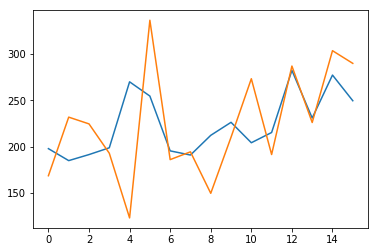

[[197.73921471 175.41667557 182.94301682]
 [184.81472206 205.49566727 241.62987518]
 [191.3423851  228.71705008 183.61098747]
 [198.6777935  166.17028313 164.18359985]
 [269.95383148 136.91800728 335.31914747]
 [254.56514587 325.68088341 174.32847347]
 [195.35334778 267.50113525 132.78976135]
 [190.835637   177.29485397 246.81744385]
 [212.14321404 185.33499527 196.18174706]
 [226.19670868 206.85608182 285.39955311]
 [204.13408909 314.7495163  159.16250458]
 [215.20095139 226.04024734 302.55339432]
 [282.34499207 291.01267767 262.5463295 ]
 [230.85667038 288.71617126 266.27214966]
 [277.254776   306.14543805 333.73198929]
 [249.5161644  342.12071838 402.50091896]]
[[180.3]
 [168.5]
 [231.8]
 [224.5]
 [192.8]
 [122.9]
 [336.5]
 [185.9]
 [194.3]
 [149.5]
 [210.1]
 [273.3]
 [191.4]
 [287. ]
 [226. ]
 [303.6]
 [289.9]]


In [48]:
predictions = show_train_fit(origin_y_train)

plt.plot(predictions[:, :1]) # y_hat : blue line. t+1만 관찰.
plt.plot(origin_y_train[diff_interval:, :1]) # y_train_origin : yellow line. t+1만 관찰.
plt.show()

print(predictions)
print(origin_y_train[:, :1])
# print(get_recent_prediction())

In [340]:
-- todo
x_train_series 때문에 한칸 밀린듯

SyntaxError: invalid syntax (<ipython-input-340-5edd6ecb85f5>, line 2)

## Bitcoin dataset

https://www.blockchain.com/ko/charts/market-price?timespan=60days

In [12]:
market = pd.read_csv("dataset/market-price.csv")

In [14]:
type(market.shape)

tuple